In [1]:
#import libraries needed
import numpy as np
import scipy.sparse.linalg
import pandas as pd
import matplotlib.pyplot as plt

import math

# PCA and LDA comparison

The task for this exercise is to compare PCA and LDA in their ability to cluster when projecting very high-dimensional datapoints to 2 or 3 dimensions. 

In particular, consider the dataset MNIST provided on Virtuale. This dataset contains images of handwritten digits with dimension 28x28, together with a number from 0 to 9 representing the label. 

You are asked to:

#### 1. Load the dataset in memory and explore its head and shape to understand how the informations are placed inside of it

In [2]:
#Load data into memory
data = pd.read_csv('./data.csv')

print(data.head())
print(data.shape)

# We can skip data cleaning because dataset is already processed

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

#### 2. Split the dataset into the X matrix of dimension dxN, with d = 784 (28 x 28) being the dimension of each datum, N (42000) is the number of datapoints, and Y $\in$ $R^N$ containing the corresponding labels

Dataset has 42.000 observation of 28 x 28 dimesion

Flattening: when you take a matrix and convert it into a vector by concatenating the rows. 
There is an additional coulumn (the first one) which is the label of the row. 
It represent the number hand written in the matrix flattered in the row.

flattening 28 x 28 -> 784 = 28*28 dimensional vector

We now have to split data into a matrix X and a vector Y where:
- X is dimension (784, 42000)
- Y is dimension (42000, )
- Y is the first coulumn of data, while X is the rest

In [3]:
#Convert data into a matrix
data = np.array(data)   #we will lose the name of the columns and the row number
print(data.shape)

X0 = data[:, 1:].T
print(X0.shape)

Y0 = data[:, 0]
print(Y0.shape)

(42000, 785)
(784, 42000)
(42000,)


### How to visualize images?

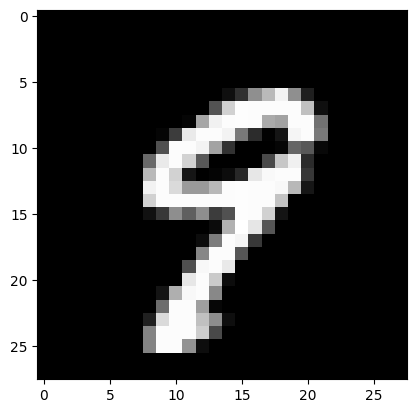

The associated digit is: 9


In [4]:
#Visualize the image of index 'idx' from the dataset 'X'
def visualize(X, idx):
    #Load an image in memory
    img = X[:,idx] 

    #Reshaspe --> opposite of flattening: from vector to matrix
    img = np.reshape(img, (28, 28)) 

    #Visualize
    plt.imshow(img, cmap='gray')     #cmap: how to convert pixel in colors
    plt.show()

#Visualize image number 9 and the corresponding digit
idx = [index for index, elem in enumerate(Y0) if elem == 9]
visualize(X0, idx[0])
print(f"The associated digit is: {Y0[idx[0]]}") #the correspondence

#### 3. Choose a number of digits (for example, 0, 6 and 9) and extract from X and Y the sub-dataset containing only the considered digits. 
Re-call X and Y those datasets, since the originals are not required anymore.

In [5]:
classes = [0, 6, 9]
idx = [index for index, elem in enumerate(Y0) if elem in classes]

X = X0[:, idx]     #take all the rows and just the columns idx
Y = Y0[idx]

print(X.shape, Y.shape)

(784, 12457) (12457,)


#### 4. Set N_train < N and randomly sample a training set with N_train datapoints from X (and the corresponding Y). Call them X_train and Y_train. Everything else is the test set. Call it X_test and Y_test.

Create a function implementing the split. It takes as input the dataset X and an integer Ntrain and returns 4 arrays 
- Xtrain: composed by Ntrain random samples from X
- Xtest: is the rest of the array X
- Ytrain and Ytest accordingly

Limitation: the sample has to be random (numpy.random.shuffle)
Example: if Ntrain = 30000 on our MNIST data, the shapes should be:
- Xtrain  (784, 30000)
- Xtest (784, 12000)
- Ytrain (30000, )
- Ytest (12000, )

In [6]:
def split_data(X, Y, Ntrain):

    d, N = X.shape

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[:, train_idx]
    Ytrain = Y[train_idx]
    
    Xtest = X[:, test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

In [7]:
Ntrain = 8000

(Xtrain, Ytrain) ,(Xtest, Ytest) = split_data(X,Y,Ntrain)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(784, 8000) (784, 4457) (8000,) (4457,)


#### 5. Implement the algorithms computing the PCA and LDA of Xtrain with a fixed k. Visualize the results (for k = 2) and the position of the centroid of each cluster.

To implement PCA, we first need to center the data. This can be done by defining its centroid.

In [8]:
def get_centroid(X):
    return np.mean(X, axis=1)   #axis = 1: applied by row

In [9]:
def PCA(X, k):
    centroidX = get_centroid(X)
    r, = centroidX.shape
    centroidX = np.reshape(centroidX, (r, 1))
    X_c = X - centroidX

    U, S, VT = np.linalg.svd(X_c, full_matrices=False) #full_matrices=false -> the shapes are (..., M, K) and (..., K, N), respectively, where K = min(M, N)

    U_k = U[:, :k]
    Z_k = U_k.T @ X_c

    return Z_k, U_k

In [10]:
def LDA(Xtrain, Ytrain, k):
    d, N = Xtrain.shape

    #Find the corresponding indeces
    I1 = (Ytrain==0) 
    I2 = (Ytrain==6)
    I3 = (Ytrain==9)

    X1 = Xtrain[:, I1]
    Y1 = Ytrain[I1]

    X2 = Xtrain[:, I2]
    Y2 = Ytrain[I2]

    X3 = Xtrain[:, I3]
    Y3 = Ytrain[I3]

    X = np.concatenate((X1, X2, X3), axis=1)
    Y = np.concatenate((Y1, Y2, Y3))

    # Class centroids
    c1 = get_centroid(X1)
    c1 = np.reshape(c1, (d, 1))

    c2 = get_centroid(X2)
    c2 = np.reshape(c2, (d, 1))

    c3 = get_centroid(X3)
    c3 = np.reshape(c3, (d, 1))

    # Global centroid
    C = get_centroid(X)

    #Within-clusters Scatter Matrix
    X_c1 = X1 - c1  #c1 was reshaped to do difference between matrix and column vector 
    X_c2 = X2 - c2
    X_c3 = X3 - c3

    X_w = np.concatenate((X_c1, X_c2, X_c3), axis=1)

    S_w = X_w @ X_w.T

    # Between-clusters Scatter Matrix
    X1_bar = np.repeat(c1, X1.shape[1], axis=1)
    X2_bar = np.repeat(c2, X2.shape[1], axis=1)
    X3_bar = np.repeat(c2, X3.shape[1], axis=1)

    X_bar = np.concatenate((X1_bar, X2_bar, X3_bar), axis=1)
   
    Xc_bar = X_bar - C.reshape(d,1)
    S_b = Xc_bar @ Xc_bar.T

    #We want to compute the Cholesky decomposition
    try:
        L = np.linalg.cholesky(S_w)
    except:
        eps = 1e-6
        S_w = S_w + eps * np.eye(S_w.shape[0])
        
        L = np.linalg.cholesky(S_w)

    _, W = scipy.sparse.linalg.eigs(np.linalg.inv(L) @ S_b @ L, k=k) #the two largest eigenvalues andd the corresponding eigenvector
    W = np.real(W)
    
    Q = np.linalg.inv(L).T @ W

    Z = Q.T @ X

    return Z, Q

In [11]:
def plot(Z, Y, extraPoint = []):
    zero=plt.scatter(Z[0,Y==0],Z[1,Y==0],marker="o", color='green')
    six=plt.scatter(Z[0,Y==6],Z[1,Y==6],marker="o", color='blue')
    nine=plt.scatter(Z[0,Y==9],Z[1,Y==9],marker="o", color='pink')

    clusters = [zero, six, nine]

    c0 = get_centroid(Z[:, Y==0])
    plt.scatter(c0[0], c0[1], marker='*', color='red')

    c6 = get_centroid(Z[:, Y==6])
    plt.scatter(c6[0], c6[1], marker='*', color='red')

    c9 = get_centroid(Z[:, Y==9])
    plt.scatter(c9[0], c9[1], marker='*', color='red')

    centroids = [c0, c6, c9]

    plt.grid()
    plt.legend((zero,six,nine),("zero","six","nine"))

    if(len(extraPoint)!=0):
        plt.scatter(extraPoint[0], extraPoint[1], marker='*', color="yellow")

    plt.show()

    return clusters, centroids

In [12]:
def centroid_of_cluster(Z, Y, label):
    '''
    Z is the reduced dataset
    Y is the labels array
    label is the class of the cluster
    '''
    return get_centroid(Z[:, Y==label])

PCA
(2, 8000)


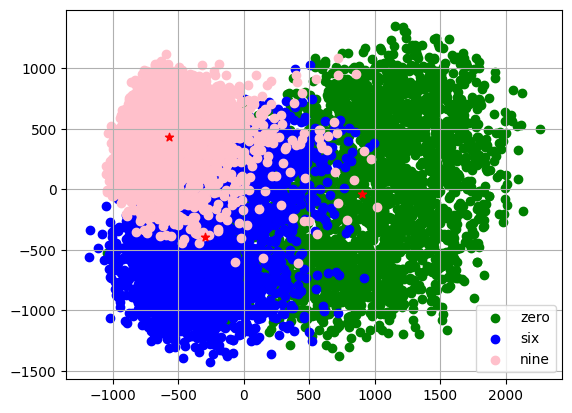

LDA


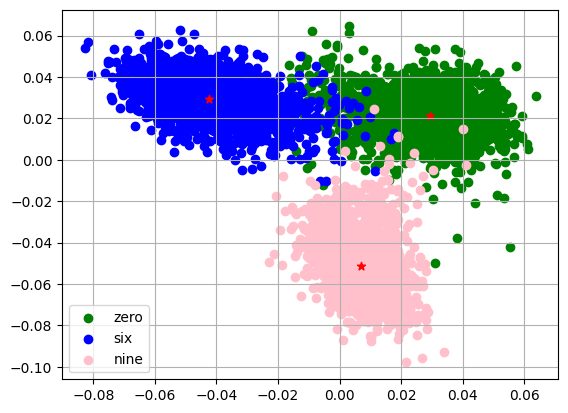

In [13]:
#PCA
print("PCA")
Z_pca, proj_PCA = PCA(Xtrain, 2)
print(Z_pca.shape)
cluster_pca, centroid_pca = plot(Z_pca, Ytrain)

#LDA
print("LDA")
Z_lda, proj_LDA = LDA(Xtrain, Ytrain, 2)
Y1 = Ytrain[Ytrain==0]
Y2 = Ytrain[Ytrain==6]
Y3 = Ytrain[Ytrain==9]
Y_lda = np.concatenate((Y1,Y2,Y3))
cluster_lda, centroid_lda = plot(Z_lda, Y_lda)

#### 6. For both the algorithms, compute for each cluster the average distance from the centroid. Comment the result. 

In [14]:
def distance_cluster_centroid(clusters, centroids):
    centroid_index = 0
    distances = []

    for el in clusters:
        points = el.get_offsets().data
        r, c = points.shape

        dist_point_centr = []

        for i in range(r):
            d = np.linalg.norm(points[i] - centroids[centroid_index], 2)
            dist_point_centr.append(d)

        average = sum(dist_point_centr)/r
        distances.append(average)

        centroid_index += 1
    
    return distances

In [15]:
distances_pca = distance_cluster_centroid(cluster_pca, centroid_pca)
print(f"PCA distances: 0 --> {distances_pca[0]}, \t 6--> {distances_pca[1]}, \t 9--> {distances_pca[2]}")

distances_lda = distance_cluster_centroid(cluster_lda, centroid_lda)
print(f"LDA distances: 0 --> {distances_lda[0]}, \t 6--> {distances_lda[1]}, \t 9--> {distances_lda[2]}")

PCA distances: 0 --> 731.0849566449853, 	 6--> 537.0418483741173, 	 9--> 365.15463744365906
LDA distances: 0 --> 0.013655523662814884, 	 6--> 0.013347710415941868, 	 9--> 0.012633698575117525


#### 7. For both the algorithms, compute for each cluster the average distance from the centroid on the test set. Comment the results.

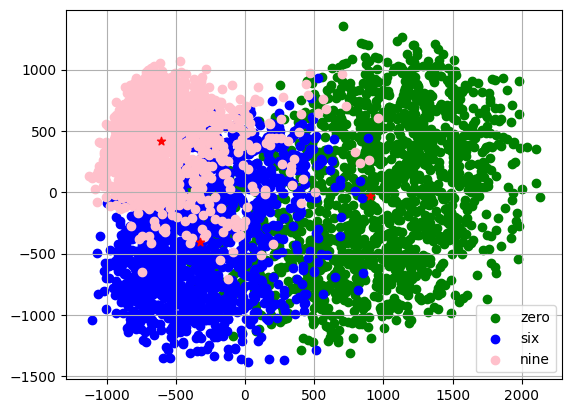

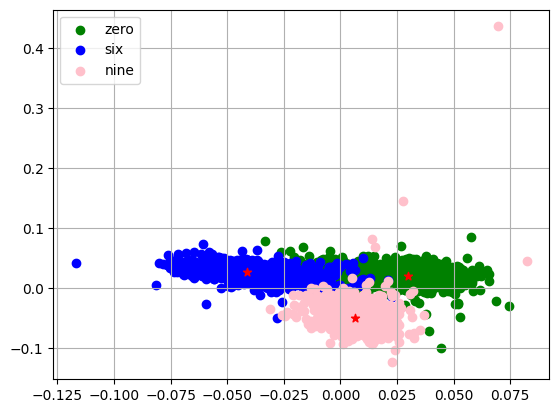

PCA distances: 0 --> 723.8402249632471, 	 6--> 534.0355565142878, 	 9--> 358.3781690836275
LDA distances: 0 --> 0.015464729996276561, 	 6--> 0.014922541158389138, 	 9--> 0.014843811951318614


In [16]:
centroidX_test = get_centroid(Xtest)
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
clusters_pca, centroids_pca = plot(Z_pca_test, Ytest)

Z_lda_test = proj_LDA.T @ Xtest
clusters_lda, centroids_lda = plot(Z_lda_test, Ytest)

distances_pca_test = distance_cluster_centroid(clusters_pca, centroids_pca)
print(f"PCA distances: 0 --> {distances_pca_test[0]}, \t 6--> {distances_pca_test[1]}, \t 9--> {distances_pca_test[2]}")

distances_lda_test = distance_cluster_centroid(clusters_lda, centroids_lda)
print(f"LDA distances: 0 --> {distances_lda_test[0]}, \t 6--> {distances_lda_test[1]}, \t 9--> {distances_lda_test[2]}")

#### 8. Define a classification algorithm in this way: given a new observation x, compute the distance between x and each cluster centroid. Assign x to the class corresponding the closer centroid. Compute the accuracy of this algorithm on the test set and compute its accuracy for both PCA and LDA

In [17]:
def classification_algorithm(obs, centroids, gt):
    distance_proj_clusters = []

    for i in range (len(centroids)):
        d = np.linalg.norm(obs - centroids[i], 2)
        distance_proj_clusters.append(d)

    min_index = np.argmin(distance_proj_clusters)

    predicted_class = classes[min_index]

    return predicted_class == gt

def accuracy(X, centroids, Y):
    results = [classification_algorithm(X[:, i], centroids, gt) for i, gt in enumerate(Y)]

    correct_pred = np.sum(results)

    correctness = correct_pred / len(Y)
    print(f'Percentage of correct classifications: {correctness}')
    
    return correctness

In [18]:
Z_pca_test =  proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))
Z_lda_test = proj_LDA.T @ Xtest

print('PCA')
accuracy_pca = accuracy(Z_pca_test, centroids_pca, Ytest)

print('LDA')
accuracy_lda = accuracy(Z_lda_test, centroids_lda, Ytest) 

PCA
Percentage of correct classifications: 0.8523670630468926
LDA
Percentage of correct classifications: 0.9744222571236257


#### 9. Repeat this experiment for different values of k and different digits. What do you observe?

In [38]:
def try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, k):

    print(f"k={k}")

    Zpca, new_proj_PCA = PCA(Xtrain, k)
    Zlda, new_proj_LDA = LDA(Xtrain, Ytrain, k)

    centroidX_test = get_centroid(Xtest)
    Z_test_pca_new = new_proj_PCA.T @ (Xtest - np.reshape(centroidX_test, (len(centroidX_test), 1)))

    Z_test_lda_new = new_proj_LDA.T @ Xtest

    centroids_pca_new = []
    centroids_lda_new = []

    for label in classes: 
        centroids_pca_new.append(centroid_of_cluster(Z_test_pca_new, Ytest, label))
        centroids_lda_new.append(centroid_of_cluster(Z_test_lda_new, Ytest, label))

   
    print('PCA')
    accuracy_pca = accuracy(Z_test_pca_new, centroids_pca_new, Ytest)

    print('LDA')
    accuracy_lda = accuracy(Z_test_lda_new, centroids_lda_new, Ytest)

k_test = np.array((2, 50, 100, 500))

for k in k_test:
    try_PCA_LDA(Xtrain, Ytrain, Xtest, Ytest, k)


k=2
PCA
Percentage of correct classifications: 0.8523670630468926
LDA
Percentage of correct classifications: 0.9744222571236257
k=50
PCA
Percentage of correct classifications: 0.9528831052277317
LDA
Percentage of correct classifications: 0.33924164236033205
k=100
PCA
Percentage of correct classifications: 0.9535562037244784
LDA
Percentage of correct classifications: 0.3394660085259143
k=500
PCA
Percentage of correct classifications: 0.9535562037244784
LDA
Percentage of correct classifications: 0.3390172761947498
